In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import csv
from tqdm import tqdm
import multiprocessing
from functools import partial
from PIL import Image

In [3]:
def get_files(folder):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]

def get_folders(folder):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.isdir(os.path.join(folder, f))]

In [4]:
dataset_folder = '/home/ysheng/Dataset/human_ds/base/'
folders = get_folders(dataset_folder)
print(len(folders))

21


In [20]:
# test_folder = folders[0]
# files = get_files(test_folder)
# test_base = files[0]

test_base = '/home/ysheng/Dataset/general_ds/base/helmet_000/pitch_30_rot_90_fov_49_shadow.npy'
base_np = np.load(test_base)
print(base_np.shape)

(256, 256, 32, 8)


In [21]:
w, h = 32, 8
base_map = np.zeros((256 * w,256 * h))
for i in range(w):
    for j in range(h):
        base_map[i * 256:(i+1) * 256, j * 256:(j+1) * 256] = base_np[:,:, i, j]

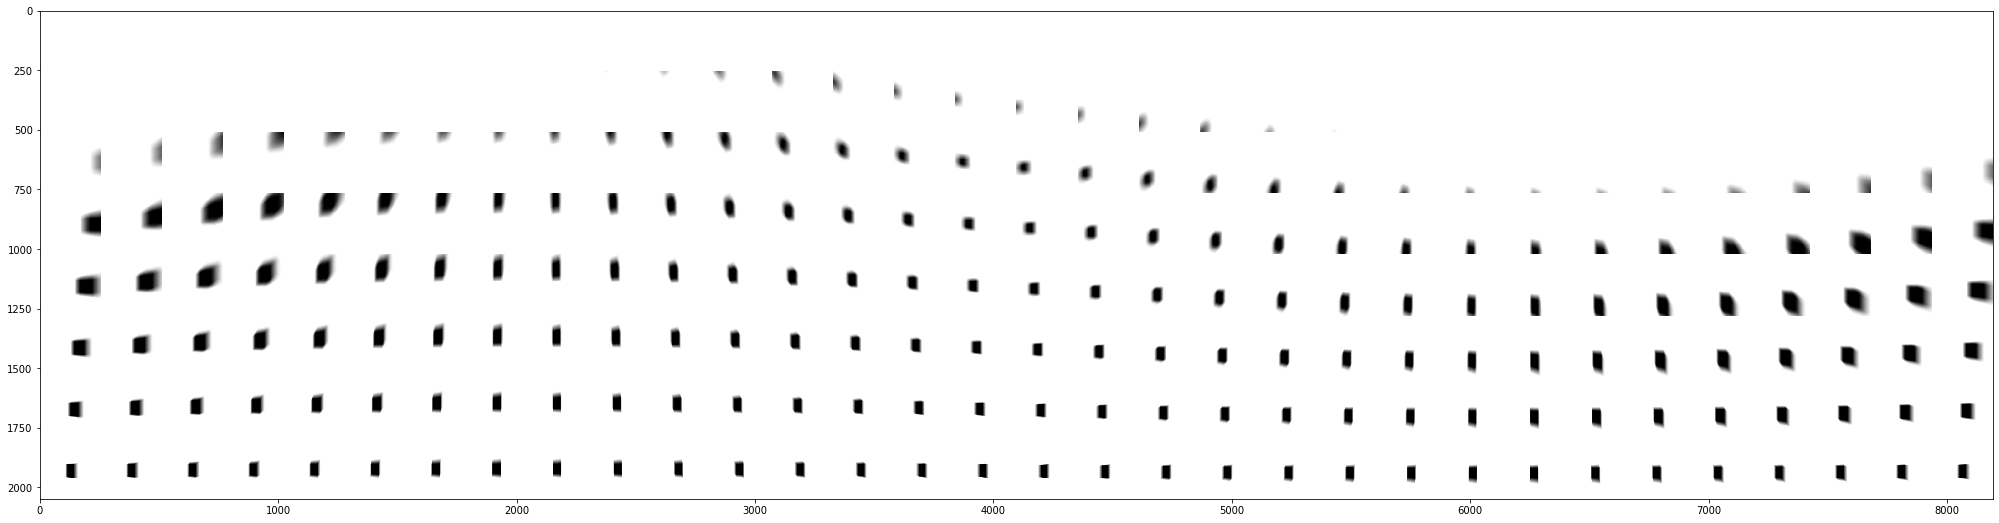

In [22]:
plt.figure(figsize=(35,30))
plt.imshow(base_map.T, cmap='gray')
plt.show()

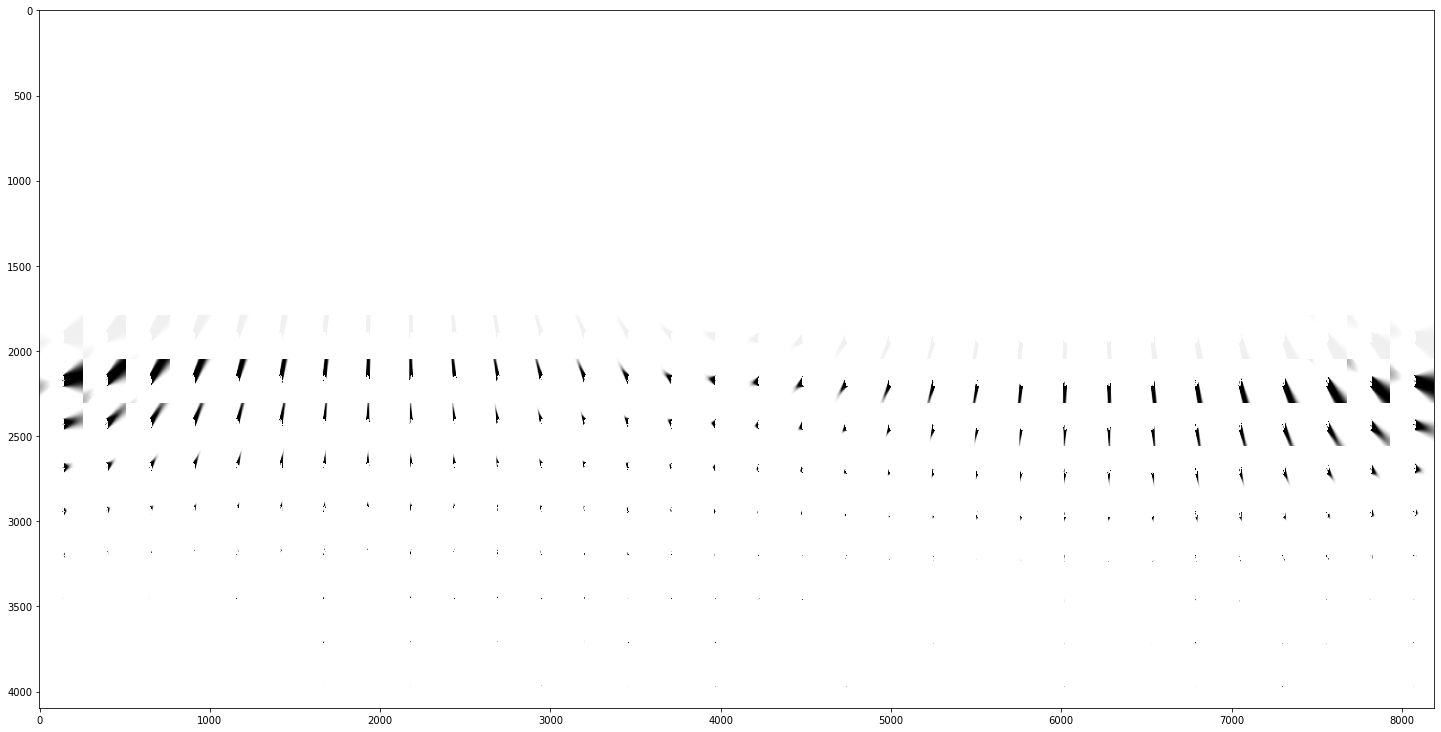

In [19]:
test_folder = '/home/ysheng/Dataset/general_dataset/base/cone_0065/'
test_base = os.path.join(test_folder, 'pitch_15_rot_0_shadow.npy')

base_np = np.load(test_base)

base_map = np.zeros((256 * 32,256 * 16))
for i in range(32):
    for j in range(16):
        base_map[i * 256:(i+1) * 256, j * 256:(j+1) * 256] = base_np[:,:, i, j]
        
plt.figure(figsize=(25,15))
plt.imshow(base_map.T, cmap='gray')
plt.show()

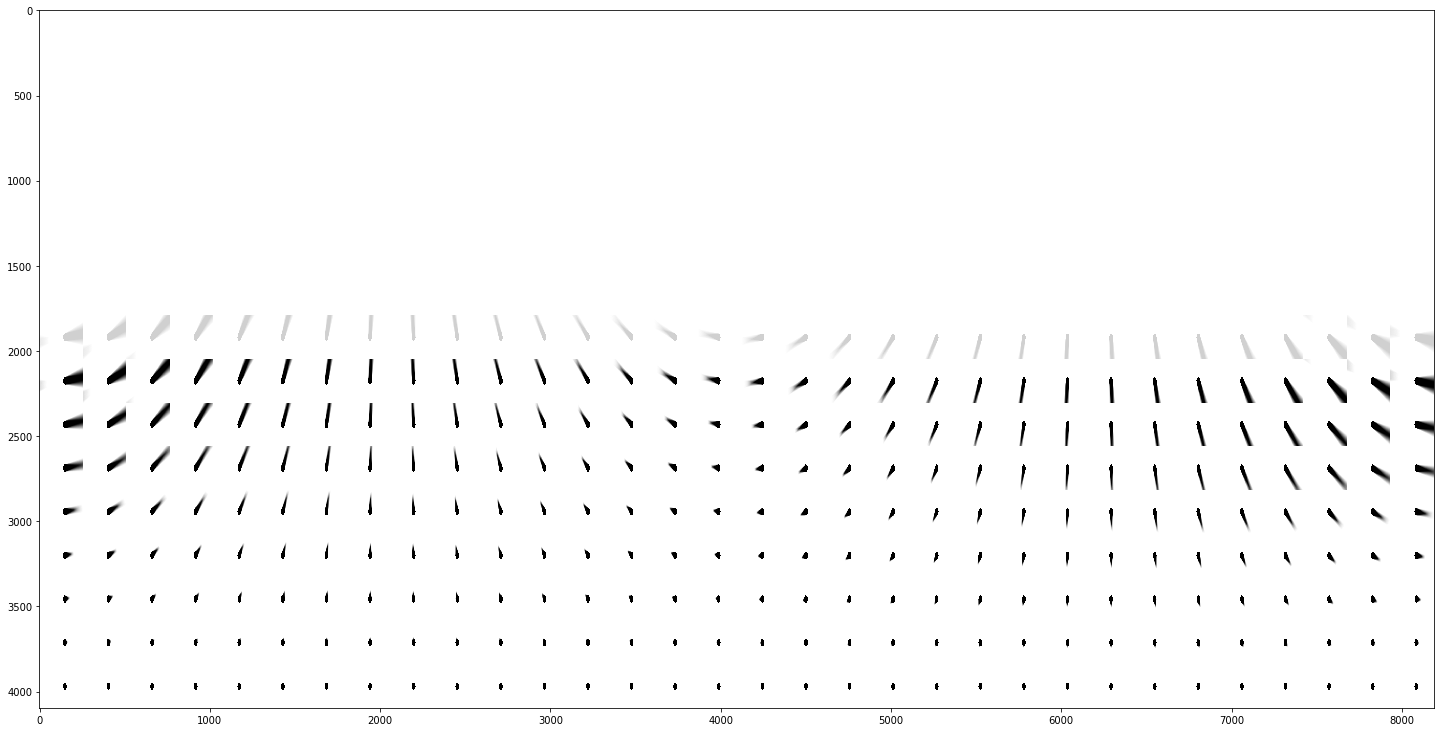

In [20]:
test_folder = '/home/ysheng/Dataset/general_dataset/base/cone_0109/'
test_base = os.path.join(test_folder, 'pitch_15_rot_0_shadow.npy')

base_np = np.load(test_base)

base_map = np.zeros((256 * 32,256 * 16))
for i in range(32):
    for j in range(16):
        base_map[i * 256:(i+1) * 256, j * 256:(j+1) * 256] = base_np[:,:, i, j]
        
plt.figure(figsize=(25,15))
plt.imshow(base_map.T, cmap='gray')
plt.show()

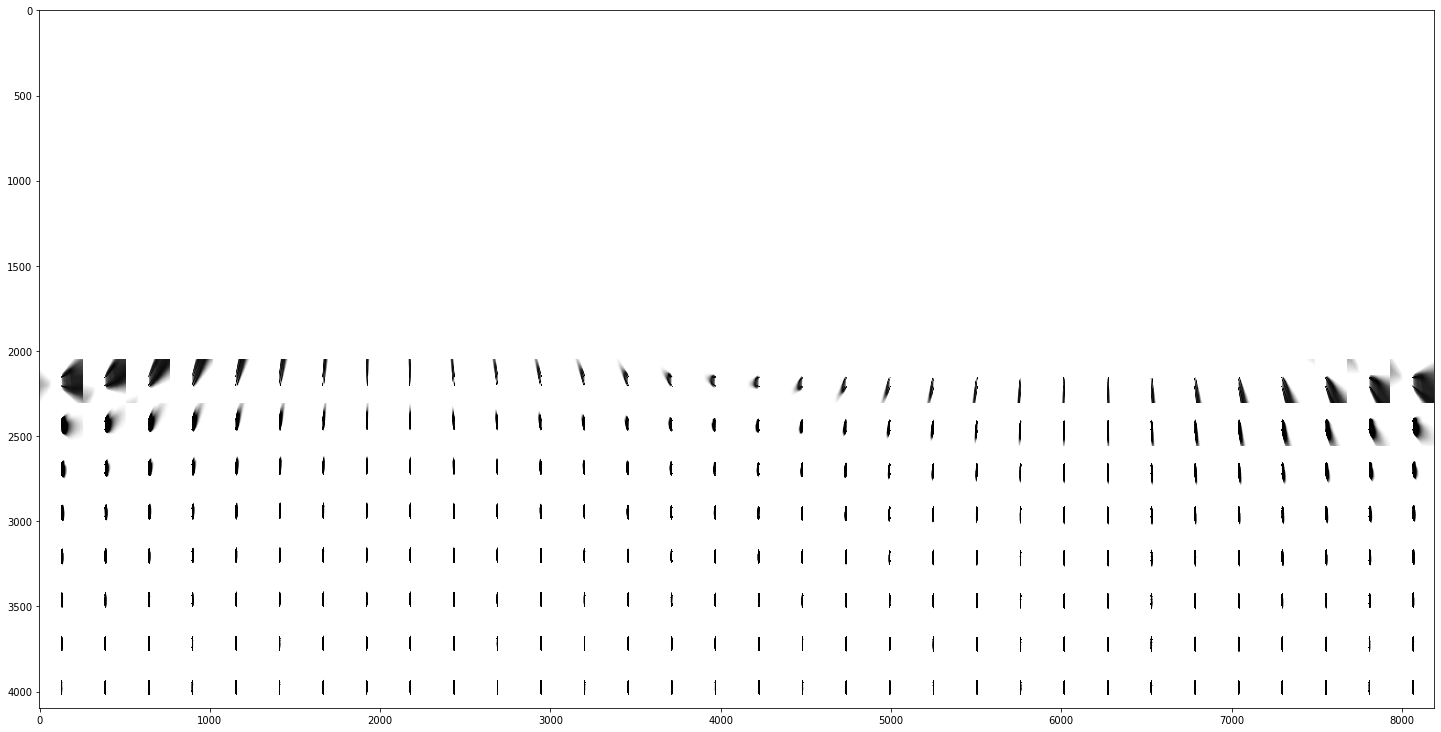

In [21]:
test_folder = '/home/ysheng/Dataset/general_dataset/base/car_0195/'
test_base = os.path.join(test_folder, 'pitch_15_rot_0_shadow.npy')

base_np = np.load(test_base)

base_map = np.zeros((256 * 32,256 * 16))
for i in range(32):
    for j in range(16):
        base_map[i * 256:(i+1) * 256, j * 256:(j+1) * 256] = base_np[:,:, i, j]
        
plt.figure(figsize=(25,15))
plt.imshow(base_map.T, cmap='gray')
plt.show()

In [11]:
print(base_np[:,:,:,-5:].shape)

(256, 256, 32, 5)


In [ ]:
path = '/home/ysheng/Dataset/soft_shadow/new_dataset/notsimulated_combine_male_short_outfits_genesis8_armani_casualoutfit03_Base_Pose_Standing_A/'
output_folder = os.path.join(path, 'base')

os.makedirs(output_folder, exist_ok=True)

gt_file = os.path.join(path, 'ground_truth.txt')
lines = []

with open(gt_file) as f:
    reader = csv.reader(f, delimiter=',')
    for r in reader:
        lines.append(r)

print('there are {} lines'.format(len(lines)))

In [ ]:
# construct the map
# [camera, human_rot] -> [[i, j]->[prefix]]
# oss << cur_prefix << ",";
# oss << light_pixel_pos.to_string() << ",";
# oss << to_string(manager.cur_camera->_position) << ",";
# oss << target_rot << ",";
# oss << to_string(render_target->compute_world_center()) << ",";
# oss << to_string(manager.m_lights[0]->m_verts[0]) << std::endl;
# gt_str.push_back(oss.str());
group_data = {}
for l in tqdm(lines):
    prefix = l[0]
    ibl = (int(l[1]), int(l[2]))
    camera_pos = (l[3], l[4], l[5])
    rot = l[6]
    target_center = (l[7], l[8], l[9])
    light_pos = (l[10], l[11], l[12])

    key = (camera_pos, rot)
    if key not in group_data.keys():
        group_data[key] = dict()

    ibl_key = ibl
    group_data[key][ibl_key] = prefix

In [ ]:
print('keys: ',len(group_data.keys()))
print('keys: ', group_data.keys())

# h x w x x x y 
h, w, x, y = 256,256, 512, 256-176 

print(h * w * x * y * 4 / 1024 / 1024 /1024)

all_data = np.zeros((h, w, x, y))

In [ ]:
info_str = ""
new_prefix = 0
img_folder = os.path.join(path, 'imgs')
x_begin, y_begin = 0, 176

meta_str, new_base_prefix = "", 0

for key_id, key in enumerate(group_data.keys()):
    # loading data
    for (ibl, prefix) in tqdm(group_data[key].items()):
        x, y = ibl
        if y < 176:
            continue
        
        if y > 255:
            print('y: {} is out of range, bug here'.format(y))
            break
        
        shadow_path = os.path.join(img_folder, prefix + '_shadow.png')
        shadow_np = plt.imread(shadow_path)
        
        cur_x, cur_y = x - x_begin, y - y_begin
        all_data[:,:, cur_x, cur_y] = shadow_np[:,:,0]
    
    # saving new dataset
    print('prepare bases')
    x_range, y_range = 8, 8
    x_iter, y_iter = 512//x_range, (256-y_begin)//y_range

    for xi in tqdm(range(x_iter)):
        for yi in range(y_iter):
            x_pos, y_pos = xi * 16, yi * 16
            new_ibl = np.sum(all_data[:,:,x_pos:x_pos + x_range, y_pos:y_pos+y_range], axis=(2,3))

            meta_str += '{},{},{},{} \n'.format(key_id, new_base_prefix,xi, yi)
            np.save(os.path.join(output_folder, '{:08d}.npy'.format(new_base_prefix)),new_ibl)
            new_base_prefix += 1

# save meta data
with open(os.path.join(output_folder, 'metadata.csv'), 'w+') as wf:
    wf.write(meta_str)

print('finsihed')

In [ ]:
# saving new dataset
print('prepare bases')
new_base_prefix = 0
x_range, y_range = 8, 8
x_iter, y_iter = 512//x_range, (256-y_begin)//y_range

for xi in tqdm(range(x_iter)):
    for yi in range(y_iter):
        x_pos, y_pos = xi * x_range, yi * y_range
        new_ibl = np.sum(all_data[:,:,x_pos:x_pos + x_range, y_pos:y_pos+y_range], axis=(2,3))

        meta_str += '{},{},{},{} \n'.format(key_id, new_base_prefix,xi, yi)
        np.save(os.path.join(output_folder, '{:08d}.npy'.format(new_base_prefix)),new_ibl)
        new_base_prefix += 1

In [ ]:
test_np = np.load(os.path.join(output_folder, '00000000.npy')) 

plt.figure()
plt.imshow(test_np, cmap='gray')
plt.show()

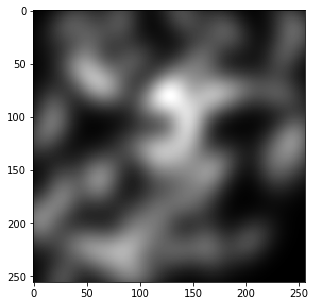

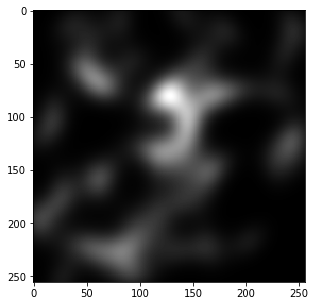

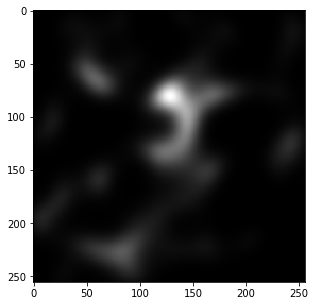

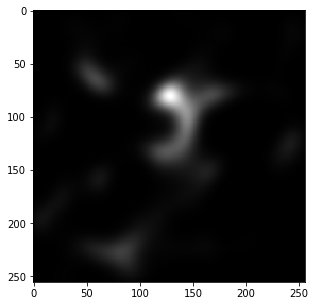

In [14]:
import numbergen as ng
import imagen as ig

def random_pattern(power=3):
    gs = ig.Composite(operator=np.add,
                  generators=[ig.Gaussian(size=0.1,
                                          x=ng.UniformRandom(seed=i+1)-0.5,
                                          y=ng.UniformRandom(seed=i+2)-0.5,
                                          orientation=np.pi*ng.UniformRandom(seed=i+3),
                                          aspect_ratio=1.0/0.71) for i in range(50)])
    ret = gs()
    ret = np.power(ret, power)
    ret = ret/np.max(ret) * 3.0
    
    return ret

def show_random_pattern(pattern):
    plt.figure(figsize=(10,5))
    plt.imshow(pattern, cmap='gray')
    plt.show()
    
    
# NdLayout(gs.anim(4)).cols(5)
for i in range(4):
    pattern = random_pattern(i+1)
    show_random_pattern(pattern)

In [15]:
path = '/home/ysheng/Dataset/soft_shadow/new_dataset/notsimulated_combine_male_short_outfits_genesis8_armani_casualoutfit03_Base_Pose_Standing_A/'
output_folder = os.path.join(path, 'base')

gs = ig.Composite(operator=np.add,
                  generators=[ig.Gaussian(size=0.1,
                                          x=ng.UniformRandom(seed=i+1)-0.5,
                                          y=ng.UniformRandom(seed=i+2)-0.5,
                                          orientation=np.pi*ng.UniformRandom(seed=i+3),
                                          aspect_ratio=1.0/0.71) for i in range(50)])

(256, 256, 31, 4)


(256, 256, 32, 5)
1.0


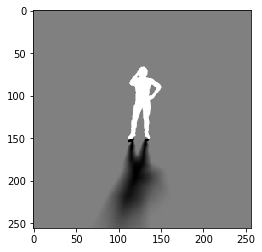

In [10]:
from skimage.transform import resize

# print('min: {}, max: {}'.format(np.min(test_np), np.max(test_np)))
# pattern = gs()
# print('pattern min: {}, max: {}, sum: {}'.format(np.min(pattern), np.max(pattern), np.sum(pattern)))
# iw,ih = 32, 5
# pattern_img = resize(pattern, (ih, iw))
# shadow = np.tensordot(test_np, pattern_img, axes=([2,3], [1,0]))
# pattern_img = np.expand_dims(resize(pattern_img, (16,32)), 2)
# print('shadow min: {}, max: {}'.format(np.min(shadow), np.max(shadow)))

test_base = '/home/ysheng/Dataset/new_dataset/base/notsimulated_combine_male_short_outfits_genesis8_armani_casualoutfit03_Base_Pose_Standing_A/pitch_15_rot_0_shadow.npy'
test_mask = '/home/ysheng/Dataset/new_dataset/cache/mask/notsimulated_combine_male_short_outfits_genesis8_armani_casualoutfit03_Base_Pose_Standing_A/pitch_15_rot_0_mask.png'
test_np = np.load(test_base) 
print(test_np.shape)
print(np.max(test_np))
test_mask = plt.imread(test_mask)

plt.figure()
plt.imshow(test_np[:,:,0,0] + test_mask[:,:,0], cmap='gray')
plt.show()

In [11]:
plt.imsave('mask.png', test_mask)
np.save('mask.npy', test_mask[:,:,0])

In [14]:
import time 
from tqdm import tqdm

iters = 1000

start = time.time()
for i in tqdm(range(iters)):
    test_np = np.load('mask.npy')
end = time.time()
print('npy time: {}s'.format(end-start))

start = time.time()
for i in tqdm(range(iters)):
    test_img = plt.imread('mask.png')
end = time.time()
print('png time: {}s'.format(end-start))

  7%|▋         | 66/1000 [00:00<00:01, 655.46it/s]

npy time: 0.31973886489868164s


100%|██████████| 1000/1000 [00:01<00:00, 640.04it/s]

png time: 1.577838659286499s


In [12]:
test_list = [0,1,2,3,4,5]
print(test_list[:5] + test_list[6:])

[0, 1, 2, 3, 4]
